In [61]:
import scanpy as sc
import scvi
import os
import anndata as ad
import pandas as pd
import harmonypy as hm

# Data Preprocessing 

<h1 style="font-size:15px;">Firstly we load the raw count feature matrices into an Anndata object which is named after their sample name. 

Each file is transposed (.T) to ensure genes are columns and cells are rows, which is the expected format for AnnData objects in Scanpy.</h1>

In [ ]:
C51ctr = sc.read_csv("data/GSM5226574_C51ctr_raw_counts.csv.gz").T
L01cov = sc.read_csv("data/GSM5226581_L01cov_raw_counts.csv.gz").T
L03cov = sc.read_csv("data/GSM5226582_L03cov_raw_counts.csv.gz").T
C52ctr = sc.read_csv("data/GSM5226575_C52ctr_raw_counts.csv.gz").T

<h1 style="font-size:15px;">This ensures that gene names in the AnnData objects are unique by appending suffixes to duplicate names, preventing conflicts during analysis.</h1>


In [36]:
C51ctr.var_names_make_unique
L01cov.var_names_make_unique
L03cov.var_names_make_unique
C52ctr.var_names_make_unique

<bound method AnnData.var_names_make_unique of AnnData object with n_obs × n_vars = 4513 × 34546>

<h1 style="font-size:15px;">This combines multiple AnnData objects into one using Scanpy's sc.concat. 

It adds a sample label to track origins and an obs['condition'] column to classify samples as covid or control based on their names.</h1>


In [ ]:
adata_list = [C51ctr, L01cov, L03cov, C52ctr]
keys = ['C51ctr', 'L01cov', 'L03cov', 'C52ctr']

adata_combined = sc.concat(
    adata_list,
    join='outer',
    keys=keys,
    label='sample',  
    index_unique=None 
)


adata_combined.obs['condition'] = adata_combined.obs['sample'].apply(
    lambda x: 'covid' if x.startswith('L') else 'control' if x.startswith('C') else 'unknown'
)

<h1 style="font-size:15px;">The following are sanity checks</h1>

In [64]:
print(adata_combined)
print(adata_combined.obs[['sample', 'condition']].head())

AnnData object with n_obs × n_vars = 18732 × 34546
    obs: 'sample', 'condition'
                      sample condition
TAGGTACCATGGCCAC-1_1  C51ctr   control
ATTCACTGTAACAGGC-1_1  C51ctr   control
TAACTTCCAACCACGC-1_1  C51ctr   control
TTGGGTACACGACAAG-1_1  C51ctr   control
AGGCCACAGAGTCACG-1_1  C51ctr   control


In [ ]:
unique_samples = adata_combined.obs['sample'].unique()
print("Unique sample names in the 'sample' column:")
print(unique_samples)


Unique sample names in the 'sample' column:
['C51ctr', 'L01cov', 'L03cov', 'C52ctr']
Categories (4, object): ['C51ctr', 'L01cov', 'L03cov', 'C52ctr']


In [ ]:
sample_counts = adata_combined.obs['sample'].value_counts()
print("Number of cells per sample:")
print(sample_counts)

Number of cells per sample:
sample
C51ctr    6099
L03cov    5060
C52ctr    4513
L01cov    3060
Name: count, dtype: int64


# Quality Control

<h1 style="font-size:15px;">This identifies mitochondrial genes and calculates the percentage of mitochondrial gene expression per cell using calculate_qc_metrics. 

Mitochondrial genes can cause issues in downstream analyis as they can be present in any type of cell dependning on the metabolic activity or lifecycle of the cell.

This can make it difficult to accurately annotate cells if there is too much mitochondrial gene expresion.</h1>


In [ ]:
adata_combined.var['mt'] = adata_combined.var_names.str.startswith('MT-')

sc.pp.calculate_qc_metrics(adata_combined, qc_vars=['mt'], percent_top=None, inplace=True)


In [68]:
adata_combined.obs

,sample,condition,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
TAGGTACCATGGCCAC-1_1,C51ctr,control,6764,8.819518,24256.0,10.096460,153.0,5.036952,0.630772
ATTCACTGTAACAGGC-1_1,C51ctr,control,6686,8.807921,19020.0,9.853299,404.0,6.003887,2.124080
TAACTTCCAACCACGC-1_1,C51ctr,control,5158,8.548498,15645.0,9.657970,221.0,5.402678,1.412592
TTGGGTACACGACAAG-1_1,C51ctr,control,4900,8.497195,15220.0,9.630431,3.0,1.386294,0.019711
AGGCCACAGAGTCACG-1_1,C51ctr,control,5544,8.620652,13217.0,9.489335,417.0,6.035481,3.155028
...,...,...,...,...,...,...,...,...,...
GATGATCTCCGCGGAT-1_2,C52ctr,control,349,5.857933,403.0,6.001415,0.0,0.000000,0.000000
TCTCACGAGCTGAAAT-1_2,C52ctr,control,343,5.840642,419.0,6.040255,0.0,0.000000,0.000000
ATGAAAGAGAGGCGGA-1_2,C52ctr,control,315,5.755742,406.0,6.008813,0.0,0.000000,0.000000
GATCAGTGTTTCGATG-1_2,C52ctr,control,318,5.765191,424.0,6.052089,0.0,0.000000,0.000000


In [ ]:
adata_combined.var_names_make_unique #for sanity

<bound method AnnData.var_names_make_unique of AnnData object with n_obs × n_vars = 18732 × 34546
    obs: 'sample', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'>

In [ ]:
adata = adata_combined #renaming to adata for convenience

<h1 style="font-size:15px;">Here we create some violin plots to viusalise the distribution of 3 key metrics.

This will help us in our decision on the thresholds for filtering our cells.</h1>


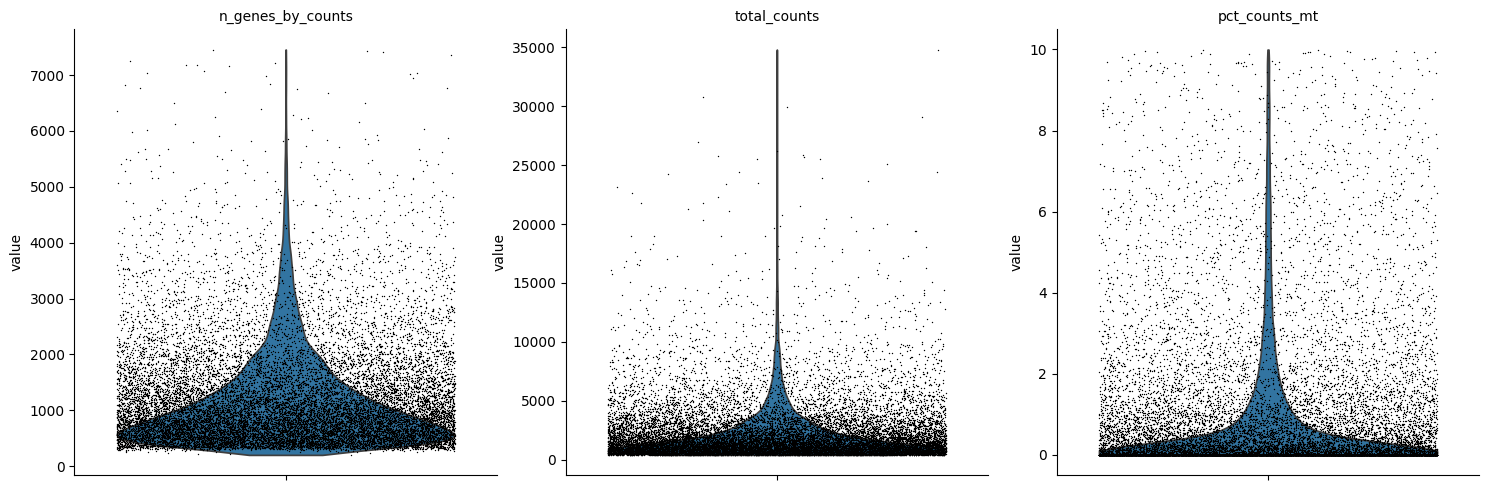

In [ ]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


<h1 style="font-size:15px;"><h1 style="font-size:15px;">The scatter plot shows the relationship between total counts (sequencing depth) and the number of detected genes per cell. 

Points are colored by the percentage of mitochondrial gene expression, which can indicate cell quality and potential stress or apoptosis.

The data shows a positive correlation between total counts and the number of detected genes, but there seems to be some having high mitochondrial gene percentages, which may indicate poor-quality or stressed cells.

This can be seen by the bright yellow spots.</h1>


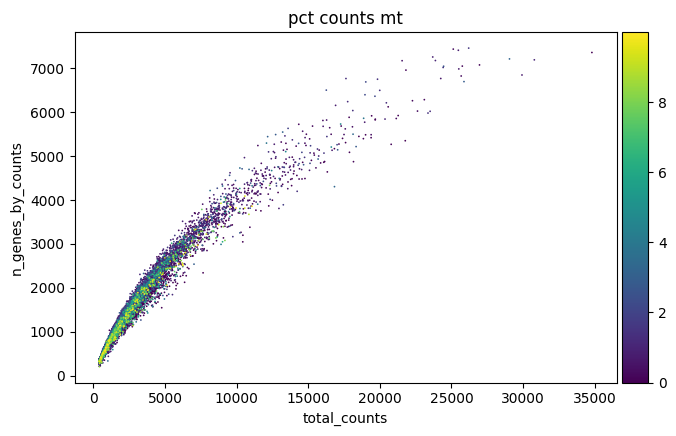

In [72]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

<h1 style="font-size:15px;">These lines filter out cells with fewer than 100 detected genes and genes expressed in fewer than 3 cells, removing low-quality data and uninformative features.

The thresholds of 100 genes per cell and 3 cells per gene are commonly used to remove low-quality cells and very rarely expressed genes, ensuring reliable downstream analysis while retaining most biologically relevant data.</h1>


In [73]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

<h1 style="font-size:15px;">
Here we are removing doublets.

This function detects potential doublets (artificially merged cells) in single-cell RNA-seq data, grouping results by the sample batch. 

Doublets can arise during library preparation and artificially inflate gene counts, potentially misleading downstream analysis. 

Removing them ensures accurate representation of true single cells.</h1>


In [74]:
sc.pp.scrublet(adata, batch_key="sample")

<h1 style="font-size:15px;">This saves a copy of the raw count matrix (`adata.X`) into a new layer called `"counts"`, preserving the original data for reference or future analyses while allowing modifications to the main matrix.</h1>


In [ ]:
adata.layers["counts"] = adata.X.copy()

<h1 style="font-size:15px;">Here we normalise each cell's total counts to the median across all cells, making data comparable.

Then we apply a natural log transformation log(1 + x) to reduce the effect of outliers and stabilize variance for downstream analyses.</h1>

In [ ]:
#Normalizing to median total counts
sc.pp.normalize_total(adata)
#Logarithmize the data
sc.pp.log1p(adata)

<h1 style="font-size:15px;">This identifies the top 2,000 highly variable genes across samples (`batch_key="sample"`), which are most informative for distinguishing cell types. Focusing on these genes reduces noise and computational load in downstream analyses.</h1>


In [77]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

<h1 style="font-size:15px;">This plot helps identify highly variable genes that contribute most to biological variation, such as cell types or states. By focusing on these genes, we improve the signal-to-noise ratio and make downstream analyses like clustering and dimensionality reduction more robust.</h1>


<h1 style="font-size:15px;">In the left panel, highly variable genes (black dots) cluster at higher normalized dispersions. 

These genes show greater variation relative to their mean expression, making them key drivers of biological differences in the dataset.</h1>


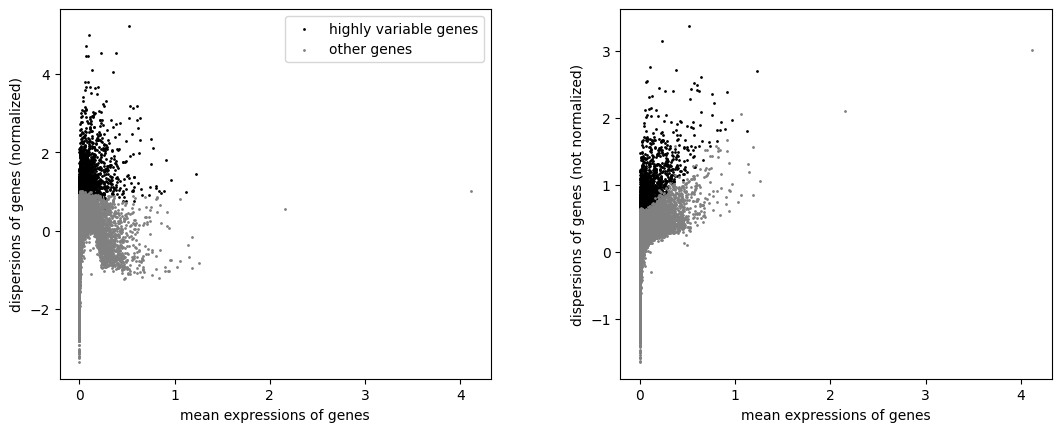

In [78]:
sc.pl.highly_variable_genes(adata)

<h1 style="font-size:15px;">Here we carry out Principal Component Analysis (PCA) on the dataset, reducing its dimensionality while capturing major sources of variation. 

This is crucial for visualization and accelerating downstream analyses like clustering.</h1>


In [79]:
sc.tl.pca(adata)

<h1 style="font-size:15px;">In this plot we can see the variance explained of each principal component in relation to each other.

The steep negative slope for the first few PCs indicates these show higher variability and will have a greater effect when performing clustering.

Generally the elbow is the cut-off for how many PCs should be kept for computing neighbours.</h1>

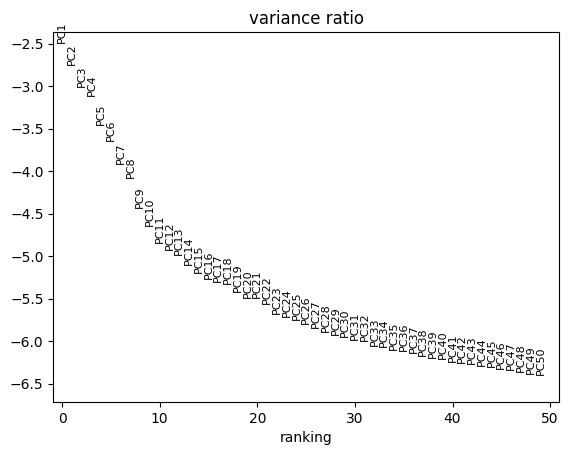

In [80]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

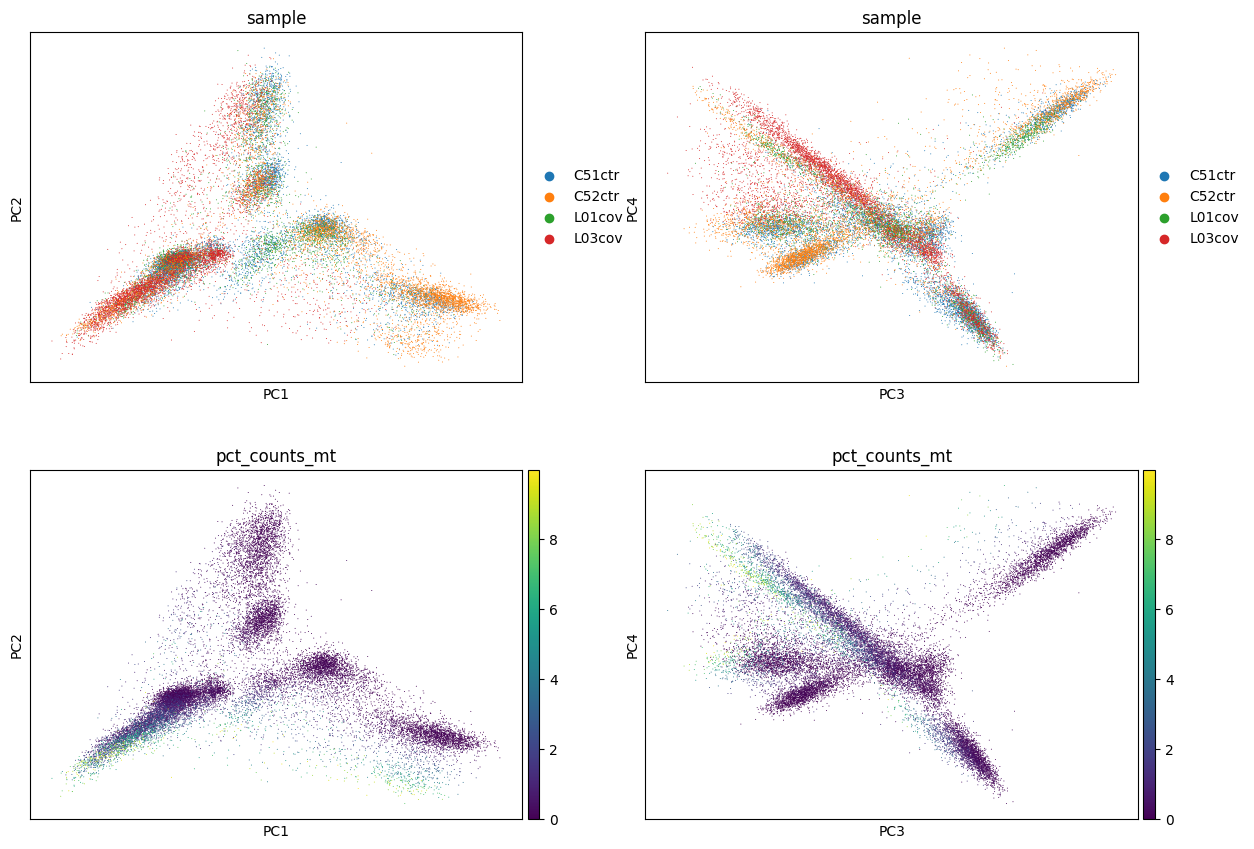

In [81]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [58]:
sc.tl.umap(adata)

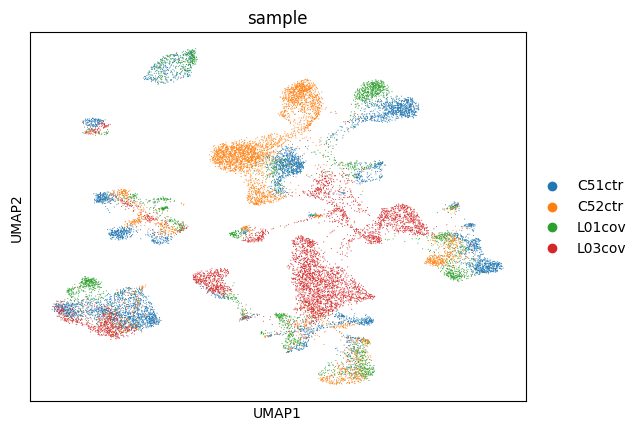

In [59]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

In [88]:
# Extract PCA embeddings and metadata
data_mat = adata.obsm["X_pca"].T if adata.obsm["X_pca"].shape[0] < adata.n_obs else adata.obsm["X_pca"]
meta_data = adata.obs[['sample']]
vars_use = ['sample']

# Run Harmony batch correction
harmony_output = hm.run_harmony(data_mat, meta_data, vars_use=vars_use)

# Assign the corrected PCA embeddings
adata.obsm['X_pca_harmony'] = harmony_output.Z_corr.T

2025-01-13 20:32:59,609 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-13 20:33:12,846 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-13 20:33:12,940 - harmonypy - INFO - Iteration 1 of 10
2025-01-13 20:33:20,232 - harmonypy - INFO - Iteration 2 of 10
2025-01-13 20:33:27,604 - harmonypy - INFO - Iteration 3 of 10
2025-01-13 20:33:34,913 - harmonypy - INFO - Iteration 4 of 10
2025-01-13 20:33:42,306 - harmonypy - INFO - Iteration 5 of 10
2025-01-13 20:33:47,346 - harmonypy - INFO - Converged after 5 iterations


In [89]:
print("Original PCA shape:", adata.obsm["X_pca"].shape)
print("Data matrix shape for Harmony:", data_mat.shape)
print("Corrected PCA shape:", harmony_output.Z_corr.shape)


Original PCA shape: (18732, 50)
Data matrix shape for Harmony: (18732, 50)
Corrected PCA shape: (50, 18732)


In [107]:
# Recompute neighbors, clustering, and UMAP
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=17)  # Using RAPIDS for GPU acceleration
sc.tl.leiden(adata, resolution=0.2)
sc.tl.umap(adata, min_dist=0.2)

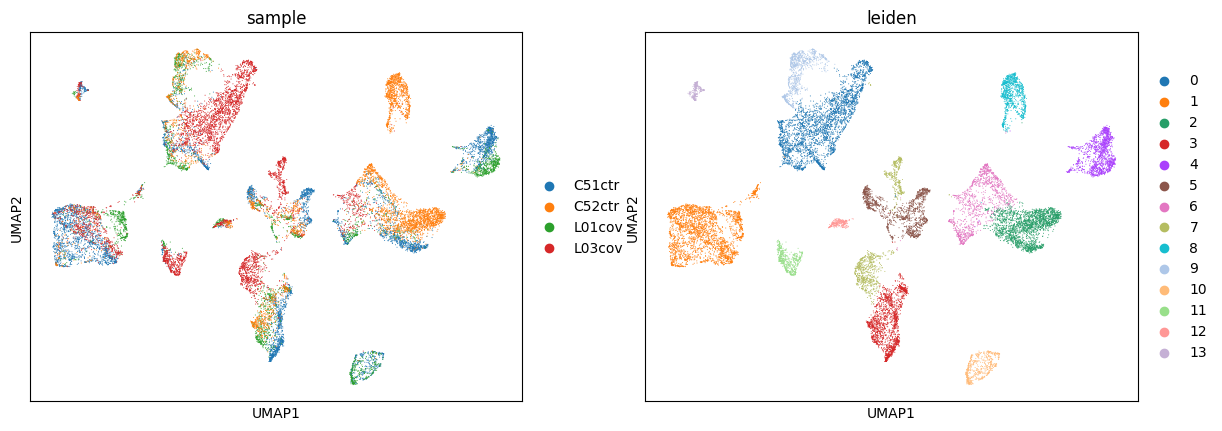

In [108]:
sc.pl.umap(
    adata,
    color=["sample", "leiden"],
    # Setting a smaller point size to get prevent overlap
    size=2,
)

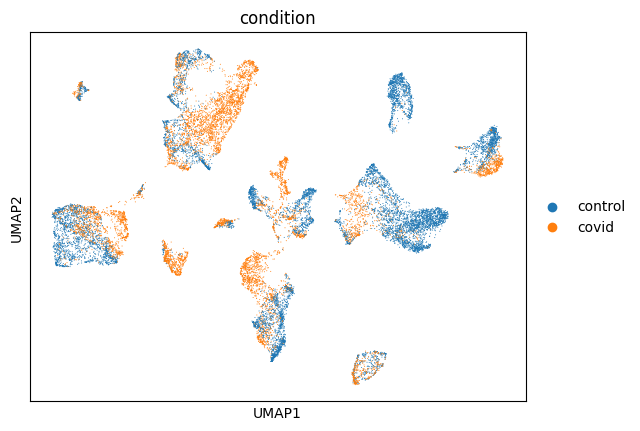

In [115]:
sc.pl.umap(
    adata,
    color=["condition"],
    # Setting a smaller point size to get prevent overlap
    size=2,
)

In [109]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')


In [110]:
sc.tl.dendrogram(adata, groupby='leiden')

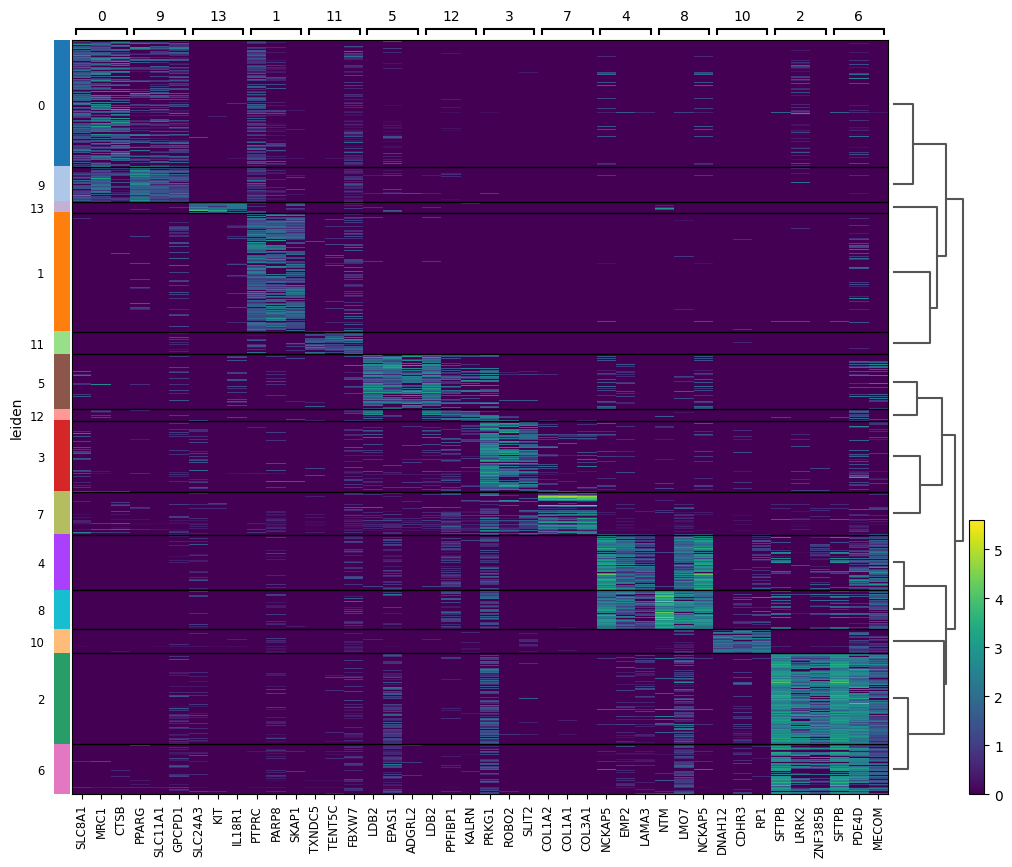

In [112]:
# Plot a larger heatmap with gene labels
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=3,                    # Number of genes to include per cluster
    groupby='leiden',             # Clustering group
    key='rank_genes_groups',      # Key for ranked genes
    cmap='viridis',               # Colormap
    show=True,                    # Show the plot
    figsize=(12, 10)              # Set the figure size (width, height) in inches
)


In [116]:
import pandas as pd

# Access the ranked genes from the results
ranked_genes = adata.uns['rank_genes_groups']

# Create a DataFrame to store the top 7 genes per cluster
top_genes_per_cluster = pd.DataFrame(
    {
        cluster: ranked_genes['names'][cluster][:10]  # Extract top 7 genes for each cluster
        for cluster in ranked_genes['names'].dtype.names
    }
)

# Rename columns for better clarity
top_genes_per_cluster.columns = [f"Cluster {col}" for col in top_genes_per_cluster.columns]

# Display the DataFrame
print(top_genes_per_cluster)

  Cluster 0 Cluster 1 Cluster 2 Cluster 3   Cluster 4 Cluster 5 Cluster 6  \
0    SLC8A1     PTPRC     SFTPB     PRKG1      NCKAP5      LDB2     SFTPB   
1      MRC1     PARP8     LRRK2     ROBO2        EMP2     EPAS1     PDE4D   
2      CTSB     SKAP1   ZNF385B     SLIT2       LAMA3    ADGRL2     MECOM   
3    PLXDC2       FYN     PDE4D   CACNA1C      NEDD4L      TCF4   MACROD2   
4      ZEB2  ARHGAP15     AGBL1     LAMA2      LIMCH1   GALNT18      ANK3   
5      PSAP     PRKCH     ERBB4     RBMS3        ROR1     SASH1    MT-CO3   
6      FMN1     IKZF1      DLG2      RORA        LMO7     DOCK9   MT-ATP6   
7     RBM47   PIP4K2A      ANK3       DST  AC027288.3     PTPRM    MT-ND1   
8      GLUL      ETS1   MACROD2     LSAMP        SCEL    PECAM1    MT-ND3   
9     CD163    CHST11     ABCA3     SLIT3       CLIC5     BMPR2     MTUS1   

  Cluster 7   Cluster 8 Cluster 9 Cluster 10 Cluster 11  Cluster 12 Cluster 13  
0    COL1A2         NTM     PPARG     DNAH12     TXNDC5        LDB2    

In [117]:
top_genes_per_cluster

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12,Cluster 13
0,SLC8A1,PTPRC,SFTPB,PRKG1,NCKAP5,LDB2,SFTPB,COL1A2,NTM,PPARG,DNAH12,TXNDC5,LDB2,SLC24A3
1,MRC1,PARP8,LRRK2,ROBO2,EMP2,EPAS1,PDE4D,COL1A1,LMO7,SLC11A1,CDHR3,TENT5C,PPFIBP1,KIT
2,CTSB,SKAP1,ZNF385B,SLIT2,LAMA3,ADGRL2,MECOM,COL3A1,NCKAP5,GPCPD1,RP1,FBXW7,KALRN,IL18R1
3,PLXDC2,FYN,PDE4D,CACNA1C,NEDD4L,TCF4,MACROD2,COL6A3,EMP2,INHBA,CFAP299,HSP90B1,ST6GALNAC3,BMP2K
4,ZEB2,ARHGAP15,AGBL1,LAMA2,LIMCH1,GALNT18,ANK3,FN1,GPRC5D-AS1,MSR1,CFAP43,JCHAIN,SEMA3A,FER
5,PSAP,PRKCH,ERBB4,RBMS3,ROR1,SASH1,MT-CO3,COL5A1,RTKN2,ALOX5,AGBL4,IFNG-AS1,PKHD1L1,SYTL3
6,FMN1,IKZF1,DLG2,RORA,LMO7,DOCK9,MT-ATP6,COL5A2,AC027288.3,TCF7L2,DNAH11,SEL1L3,STOX2,TNIK
7,RBM47,PIP4K2A,ANK3,DST,AC027288.3,PTPRM,MT-ND1,COL6A1,MAGI3,LSAMP,LRRIQ1,FNDC3B,CD36,SLC18A2
8,GLUL,ETS1,MACROD2,LSAMP,SCEL,PECAM1,MT-ND3,SPARC,KHDRBS2,FN1,SPAG17,DENND5B,APP,PRKCA
9,CD163,CHST11,ABCA3,SLIT3,CLIC5,BMPR2,MTUS1,COL6A2,COL4A3,MRC1,TMEM232,MSI2,CNKSR3,CPA3


In [146]:
cell_type = {
    "0": "Alveolar epithelial cells",  # Presence of genes like SLC8A1, PLXDC2, and CD163 indicates epithelial cells.
    "1": "T cells",  # Genes like PTPRC and FYN reinforce the T-cell annotation.
    "2": "Alveolar Type II cells",  # Expression of surfactant proteins like SFTPB and epithelial markers like ZNF385B.
    "3": "Fibroblasts",  # PRKG1, PDE4D, and structural genes like DST suggest basal or fibroblastic identity.
    "4": "Macrophages",  # Genes like NCKAP5, CD163, and immune-associated genes support macrophage identity.
    "5": "Fibroblasts",  # Genes such as LDB2, ADGRL2, and SCEL suggest fibroblast roles.
    "6": "Ciliated epithelial cells",  # Expression of SFTPB and mitochondrial genes like MT-ND3 supports ciliated epithelial identity.
    "7": "Fibroblasts",  # Genes like COL1A2, COL1A1, and SPARC are strongly associated with ECM production.
    "8": "Endothelial cells",  # Endothelial markers like NTM and PECAM1 reinforce the endothelial identity.
    "9": "Monocytes",  # Immune genes like PPARG, MRC1, and MSR1 confirm this annotation.
    "10": "Ciliated epithelial cells",  # DNAH12 and SELL13 indicate ciliated epithelial cells.
    "11": "Alveolar macrophages",  # Immune-associated genes like HSP90B1 and FCAP43 suggest alveolar macrophages.
    "12": "Club cells",  # Markers like LDB2 and BMP2K are consistent with secretory club cells.
    "13": "Dendritic cells"  # Genes like KIT and IL18R1 confirm dendritic cell identity.
}



In [147]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

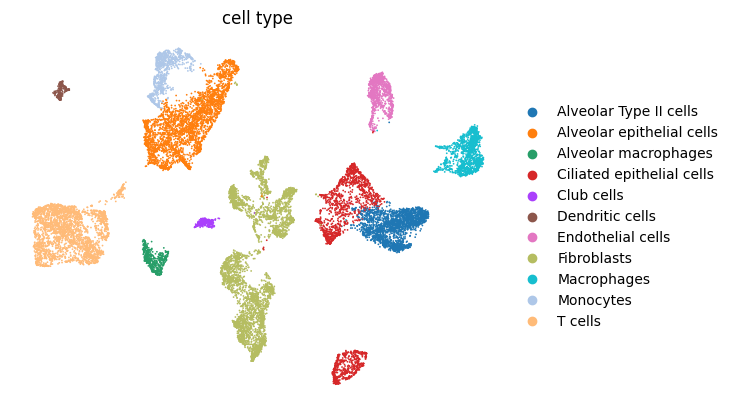

In [148]:
sc.pl.umap(adata, color = ['cell type'], frameon = False)

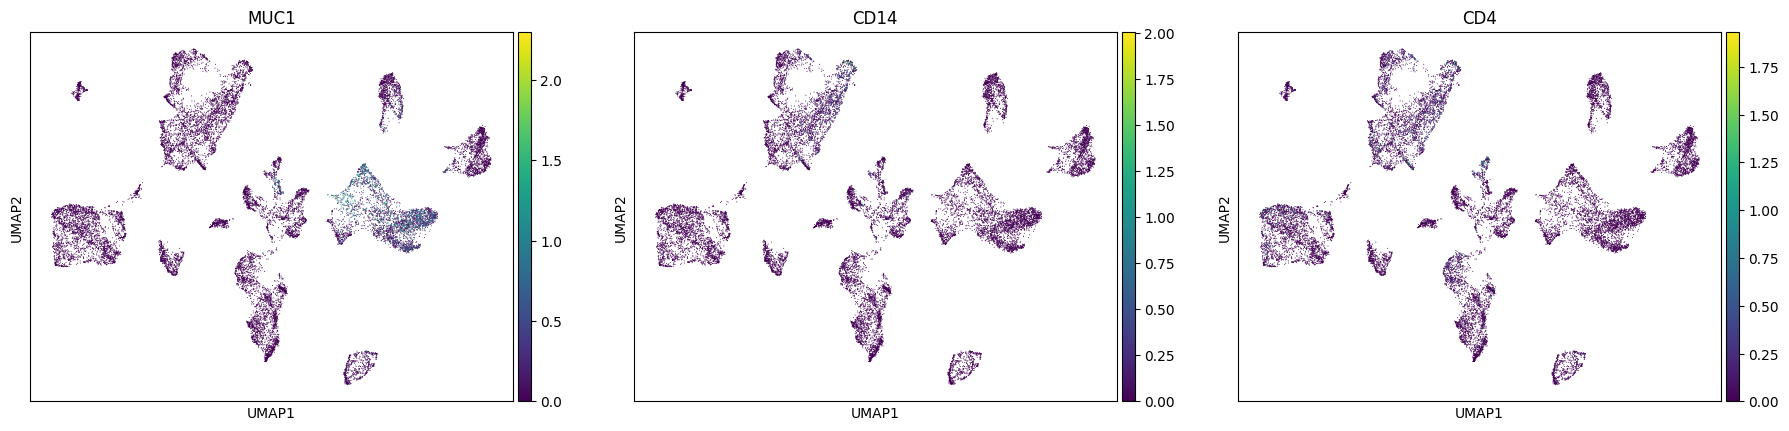

In [134]:
sc.pl.umap(
    adata,
    color=["MUC1","CD14"],
    # Setting a smaller point size to get prevent overlap
    size=2,
)

In [140]:
adata.obs

,sample,condition,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,doublet_score,predicted_doublet,leiden,cell type
TAGGTACCATGGCCAC-1_1,C51ctr,control,6764,8.819518,24256.0,10.096460,153.0,5.036952,0.630772,6751,0.013149,False,10,Ciliated epithelial cells
ATTCACTGTAACAGGC-1_1,C51ctr,control,6686,8.807921,19020.0,9.853299,404.0,6.003887,2.124080,6661,0.176667,False,10,Ciliated epithelial cells
TAACTTCCAACCACGC-1_1,C51ctr,control,5158,8.548498,15645.0,9.657970,221.0,5.402678,1.412592,5145,0.051216,False,9,Macrophages or Monocytes
TTGGGTACACGACAAG-1_1,C51ctr,control,4900,8.497195,15220.0,9.630431,3.0,1.386294,0.019711,4886,0.016312,False,10,Ciliated epithelial cells
AGGCCACAGAGTCACG-1_1,C51ctr,control,5544,8.620652,13217.0,9.489335,417.0,6.035481,3.155028,5529,0.136364,False,10,Ciliated epithelial cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GATGATCTCCGCGGAT-1_2,C52ctr,control,349,5.857933,403.0,6.001415,0.0,0.000000,0.000000,349,0.018213,False,3,Fibroblasts
TCTCACGAGCTGAAAT-1_2,C52ctr,control,343,5.840642,419.0,6.040255,0.0,0.000000,0.000000,343,0.028691,False,2,Alveolar Type II cells
ATGAAAGAGAGGCGGA-1_2,C52ctr,control,315,5.755742,406.0,6.008813,0.0,0.000000,0.000000,315,0.030928,False,8,Endothelial cells
GATCAGTGTTTCGATG-1_2,C52ctr,control,318,5.765191,424.0,6.052089,0.0,0.000000,0.000000,318,0.021238,False,8,Endothelial cells


In [149]:
num_tot_cells = adata.obs.groupby(['sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.predicted_doublet))
num_tot_cells

/tmp/ipykernel_1076828/1164800097.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata.obs.groupby(['sample']).count()


{'C51ctr': 6099, 'C52ctr': 4513, 'L01cov': 3060, 'L03cov': 5060}

In [155]:
cell_type_counts = adata.obs.groupby(['sample', 'condition', 'cell type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
cell_type_counts

/tmp/ipykernel_1076828/725658493.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata.obs.groupby(['sample', 'condition', 'cell type']).count()


,sample,condition,cell type,n_genes_by_counts
0,C51ctr,control,Alveolar Type II cells,646
1,C51ctr,control,Alveolar epithelial cells,502
2,C51ctr,control,Alveolar macrophages,56
3,C51ctr,control,Ciliated epithelial cells,646
4,C51ctr,control,Club cells,31
5,C51ctr,control,Dendritic cells,151
6,C51ctr,control,Endothelial cells,1
7,C51ctr,control,Fibroblasts,1440
8,C51ctr,control,Macrophages,848
9,C51ctr,control,Monocytes,134


In [163]:
cell_type_counts['total_cells'] = cell_type_counts['sample'].map(num_tot_cells).astype(int)
cell_type_counts['frequency'] = cell_type_counts['n_genes_by_counts'] / cell_type_counts['total_cells']

cell_type_counts

,sample,condition,cell type,n_genes_by_counts,total_cells,frequency
0,C51ctr,control,Alveolar Type II cells,646,6099,0.105919
1,C51ctr,control,Alveolar epithelial cells,502,6099,0.082309
2,C51ctr,control,Alveolar macrophages,56,6099,0.009182
3,C51ctr,control,Ciliated epithelial cells,646,6099,0.105919
4,C51ctr,control,Club cells,31,6099,0.005083
5,C51ctr,control,Dendritic cells,151,6099,0.024758
6,C51ctr,control,Endothelial cells,1,6099,0.000164
7,C51ctr,control,Fibroblasts,1440,6099,0.236104
8,C51ctr,control,Macrophages,848,6099,0.139039
9,C51ctr,control,Monocytes,134,6099,0.021971


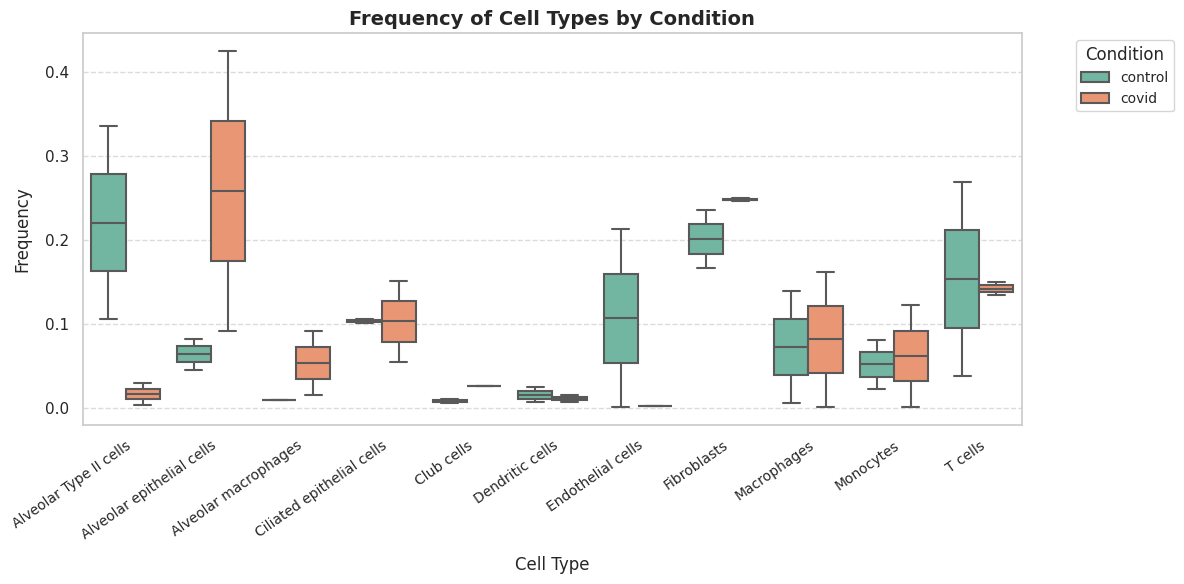

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the theme for a clean aesthetic
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size
ax = sns.boxplot(
    data=cell_type_counts,
    x='cell type',
    y='frequency',
    hue='condition',
    palette="Set2",  # Use a visually appealing palette
    linewidth=1.5  # Line thickness for better visibility
)

# Rotate x-axis labels for readability
plt.xticks(rotation=35, rotation_mode='anchor', ha='right', fontsize=10)

# Add titles and labels
plt.title("Frequency of Cell Types by Condition", fontsize=14, weight='bold')
plt.xlabel("Cell Type", fontsize=12, labelpad=10)
plt.ylabel("Frequency", fontsize=12, labelpad=10)

# Add legend outside the plot
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add grid lines for readability
ax.yaxis.grid(True, linestyle="--", alpha=0.7)

# Tighten layout to reduce spacing issues
plt.tight_layout()

# Show the plot
plt.show()



In [168]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Prepare data
X = adata.X  # Gene expression matrix
y = adata.obs['cell type']  # Annotated cell types

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Extract feature importance
feature_importance = pd.DataFrame({
    'Gene': adata.var_names,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 important genes
print(feature_importance.head(10))


          Gene  Importance
5346     ALCAM    0.007500
2145     PTPRC    0.005784
5184     PTPRG    0.005577
6327      LDB2    0.005191
6653   SHROOM3    0.004996
13964     ANK3    0.004467
22518    SKAP1    0.004372
16637    LRRK2    0.004265
7643     PDE4D    0.004252
23526   NEDD4L    0.004249
